<a href="https://colab.research.google.com/github/siting1206/NLP_HW1/blob/main/NLP_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download pre-trained model and required resources
glove-twitter-100

In [1]:
import gensim.downloader as api
wv = api.load('glove-twitter-100')

In [32]:
print(f"總共收錄了 {len(wv.vocab)} 個詞彙")
# print("印出前20個收錄的詞彙:")
# print(list(wv.vocab.keys())[:20])
# wv.most_similar("fgcu")

總共收錄了 1193514 個詞彙


Load in the required resources

In [3]:
import numpy as np
import pandas as pd
import random, os
import regex as re
import collections
from collections import namedtuple

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Processing definition
@tg10781 -> isMention<br>
http://bit.ly/dbDMs8 -> isURL<br>
17 -> isNumber......<br>



In [5]:
class RegexFeatures(object):
    PATTERNS = {
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@[\p{Alnum}_]+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print("Initialized RegexFeature")
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features

Tag = namedtuple("Tag", ["token", "tag"])

# Load train/validation dataset definition
def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences
# Load test dataset definition
def load_test_sequences(filename, sep="\t"):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
          line = line.strip()
          if line:
            seq.append(line)
          else:
            sequences.append(seq)
            seq = []
        if seq:
          sequences.append(seq)
    return sequences

### Load the dataset

In [6]:
train_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/train.txt", sep="\t", notypes=True)
dev_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/dev.txt", sep="\t", notypes=False)
test_sequences = load_test_sequences("drive/MyDrive/NLP_assignment1/data/test-submit.txt", sep="\t")

In [7]:
train_sentences = [[t[0] for t in seq] for seq in (train_sequences)]
train_tags = [[t[1] for t in seq] for seq in (train_sequences)]

valid_sentences = [[t[0] for t in seq] for seq in (dev_sequences)]
valid_tags = [[t[1] for t in seq] for seq in (dev_sequences)]

test_sentences = [[t for t in seq] for seq in (test_sequences)]

In [8]:
other_entities = {
    "isHashtag": [],
    "isMention": [],
    "isURL": [],
    "isMoney": [],
    "isNumber": [],
    "repeatedPunctuation": []
}
for seq in train_sentences:
    for t in seq:
        for k in other_entities.keys():
            if RegexFeatures.PATTERNS[k].match(t):
                other_entities[k].append(t)
# for k, v in other_entities.items():
#     print(k, len(v))

In [9]:
ENTITY_MAPPINGS={k: "__%s__" % k for k in other_entities.keys()}

### Preprocessing the token

In [10]:
def preprocess_token(x, to_lower=False):
    for k in ENTITY_MAPPINGS.keys():
        if RegexFeatures.PATTERNS[k].match(x):
            return ENTITY_MAPPINGS[k]
    if to_lower:
        x = x.lower()
    return x

In [11]:
# The words in the pretrained model glove-twitter-100 are all lower case
train_pre_seq = [[preprocess_token(t[0], to_lower=True) for t in seq] for seq in train_sequences]
dev_pre_seq = [[preprocess_token(t[0], to_lower=True) for t in seq] for seq in dev_sequences]
test_pre_seq = [[preprocess_token(t, to_lower=True) for t in seq] for seq in test_sequences]

### Splitted each sentences as a list of tuples of the words and tags.
By mapping word to index in the sequences to get y_train and y_valid

In [12]:
word2vec_sentences = [preprocess_token(t[0], to_lower=False) for seq in train_sequences for t in seq]
tag2vec_sentences = [t[1] for seq in train_sequences for t in seq]
words=list(set(word2vec_sentences))
# print(word2vec_sentences)
tags=list(set(tag2vec_sentences))
# print(tags)
w_index={t:j for j,t in enumerate(words)}
t_index={t:j+1 for j,t in enumerate(tags)}
t_word={t+1:j for t,j in enumerate(tags)}
print(t_index)
n_words = len(w_index)
n_tags = len(t_index)
y_train = [[t_index[w[1]] for w in s] for s in train_sequences]
y_valid = [[t_index[w[1]] for w in s] for s in dev_sequences]

{'I-tvshow': 1, 'I-geo-loc': 2, 'I-movie': 3, 'B-facility': 4, 'B-person': 5, 'O': 6, 'I-sportsteam': 7, 'I-other': 8, 'B-product': 9, 'B-movie': 10, 'I-person': 11, 'I-facility': 12, 'B-company': 13, 'B-sportsteam': 14, 'I-company': 15, 'I-product': 16, 'I-musicartist': 17, 'B-geo-loc': 18, 'B-tvshow': 19, 'B-musicartist': 20, 'B-other': 21}


Compute the max length to decide the array size

In [13]:
train_maxl = max([len(s) for s in train_pre_seq])
dev_maxl = max([len(s) for s in dev_pre_seq])
# print ('Maximum length in the list of train_sentences:', train_maxl)
maxl = max(train_maxl, dev_maxl)

In [14]:
embedding_matrix = wv.vectors
print(embedding_matrix.shape)

(1193514, 100)


By mapping word to index in the sequences to get X_train and X_valid
<br>If the word not in glove model, map this word to 'unk' index

In [ ]:
X_train = np.zeros([len(train_pre_seq), maxl], dtype='float32')
for i in range(len(train_pre_seq)):
  for j in range(min(len(train_pre_seq[i]),maxl)):
    try:
      X_train[i,j] = wv.vocab[train_pre_seq[i][j]].index
    except KeyError as e:
      X_train[i,j] = wv.vocab['unk'].index

X_valid = np.zeros([len(dev_pre_seq), maxl], dtype='float32')
for i in range(len(dev_pre_seq)):
  for j in range(min(len(dev_pre_seq[i]),maxl)):
    try:
      X_valid[i,j] = wv.vocab[dev_pre_seq[i][j]].index
    except KeyError as e:
      X_valid[i,j] = wv.vocab['unk'].index

X_test = np.zeros([len(test_pre_seq), maxl], dtype='float32')
for i in range(len(test_pre_seq)):
  for j in range(min(len(test_pre_seq[i]),maxl)):
    try:
      X_test[i,j] = wv.vocab[test_pre_seq[i][j]].index
    except KeyError as e:
      X_test[i,j] = wv.vocab['unk'].index

One hot encoding and padding for y_train and y_valid

In [16]:
from keras.utils import to_categorical
y_train = pad_sequences(maxlen=maxl, padding='post', sequences=y_train)
y_train = to_categorical(y_train, num_classes=22) # (2394,41)->(2394,41,22)
print(X_train.shape, y_train.shape)

y_valid = pad_sequences(maxlen=maxl, padding='post', sequences=y_valid)
y_valid = to_categorical(y_valid, num_classes=22) # (1000,41)->(1000,41,22)
print(X_valid.shape, y_valid.shape)

(2394, 41) (2394, 41, 22)
(1000, 41) (1000, 41, 22)


### Model(LSTM)

In [17]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [18]:
input=Input(shape=maxl)
model=Embedding(len(wv.vocab), 100)(input)
model=SpatialDropout1D(0.2)(model)
model=Bidirectional(LSTM(units=150,return_sequences=True, recurrent_dropout=0.1))(model)
output = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)

In [19]:
model=Model(input,output)

In [20]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 41)]              0         
                                                                 
 embedding (Embedding)       (None, 41, 100)           119351400 
                                                                 
 spatial_dropout1d (SpatialD  (None, 41, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 41, 300)          301200    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 41, 22)           6622      
 ibuted)                                                         
                                                             

In [21]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
pip install livelossplot

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

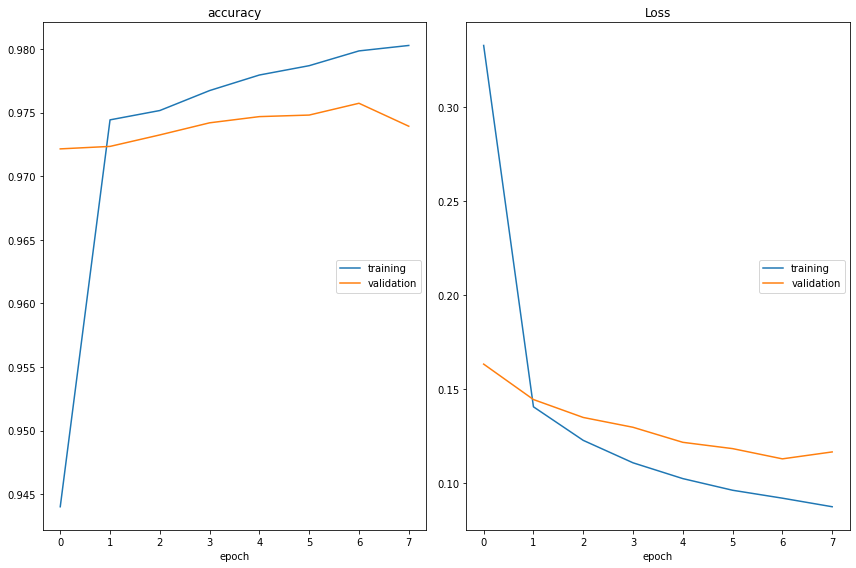

accuracy
	training         	 (min:    0.944, max:    0.980, cur:    0.980)
	validation       	 (min:    0.972, max:    0.976, cur:    0.974)
Loss
	training         	 (min:    0.088, max:    0.333, cur:    0.088)
	validation       	 (min:    0.113, max:    0.163, cur:    0.117)
75/75 [==============================] - 21s 276ms/step - loss: 0.0876 - accuracy: 0.9803 - val_loss: 0.1167 - val_accuracy: 0.9739


In [24]:
early_stop= EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stop]
history=model.fit(X_train,np.array(y_train), validation_data=(X_valid, np.array(y_valid)), batch_size=32, epochs=10, verbose=1, callbacks=callbacks)

Predict the dev dataset to evaluate

In [ ]:
true_tags = []
pred_tags = []
for i in range(0, len(X_valid)):
  pred = model.predict(np.array([X_valid[i]]))
  pred = np.argmax(pred, axis=-1)
  for j in range(0, maxl-1):
    if(pred[0][j]!=0):
      true_tags.append(valid_tags[i][j])
      pred_tags.append(t_word[pred[0][j]])
    else:
      break

## evaluating / dev 評估

In [ ]:
!pip3 install datasets
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

Evaluated by conlleval

In [27]:
from conlleval import evaluate
# print out the table as above
evaluate(true_tags, pred_tags, verbose=True) 

# calculate overall metrics
prec, rec, f1 = evaluate(true_tags, pred_tags, verbose=False)

processed 16252 tokens with 661 phrases; found: 464 phrases; correct: 141.
accuracy:  20.21%; (non-O)
accuracy:  93.45%; precision:  30.39%; recall:  21.33%; FB1:  25.07
          company: precision:  53.33%; recall:  20.51%; FB1:  29.63  15
         facility: precision:  22.73%; recall:  13.16%; FB1:  16.67  22
          geo-loc: precision:  32.45%; recall:  42.24%; FB1:  36.70  151
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            other: precision:   1.03%; recall:   0.76%; FB1:   0.87  97
           person: precision:  46.95%; recall:  45.03%; FB1:  45.97  164
          product: precision:   0.00%; recall:   0.00%; FB1:   0.00  10
       sportsteam: precision:  20.00%; recall:   1.43%; FB1:   2.67  5
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  0


Predict the test dataset and output the outcome to 'output.txt'

In [ ]:
f = open("/content/drive/MyDrive/NLP_assignment1/data/output.txt", "w")
for i in range(0, len(X_test)):
  pred = model.predict(np.array([X_test[i]]))
  pred = np.argmax(pred, axis=-1)
  for j in range(0, maxl-1):
    if(pred[0][j]!=0):
      f.write(test_sentences[i][j] + "\t" + t_word[pred[0][j]] + "\n")
    else:
      f.write("\n")
      break
f.close()

Create a requirements file

In [29]:
pip freeze > requirements.txt